In [1]:
import pymc as pm
import scipy as sp
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

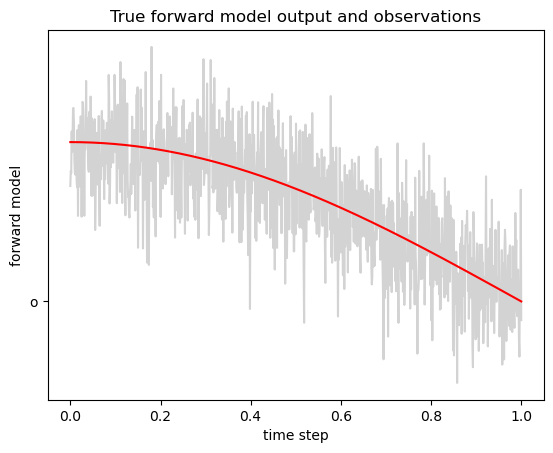

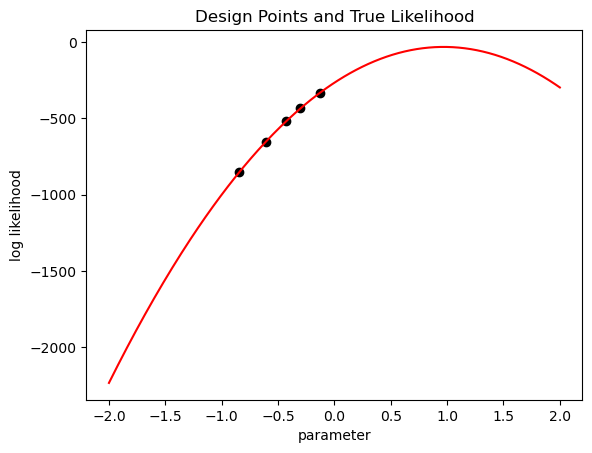

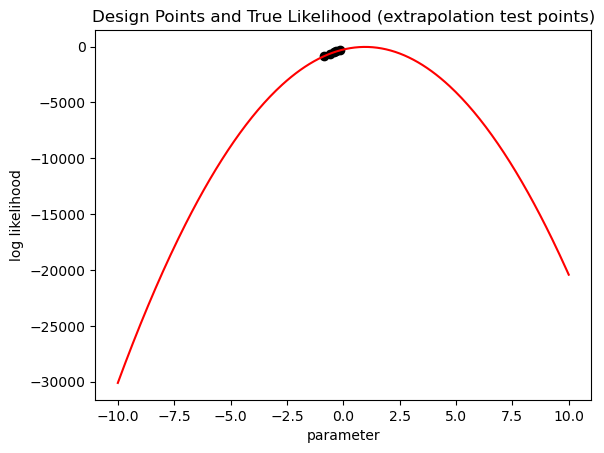

In [51]:
# Simulate data.
RANDOM_SEED = 10 
rng = np.random.default_rng(RANDOM_SEED)

# Settings. 
sig = 0.25 
par_true = 1.0 
n_obs = 10
n_time_steps = 1000
n_design = 5
n_test = 300

# Forward model: linear combination of periodic basis functions. 
time_steps = np.linspace(start=0, stop=1, num=n_time_steps)
G = lambda par : par * np.cos(np.pi*time_steps/2)

# True (latent) signal and observed data. 
g_true = G(par_true)
y = g_true + rng.normal(loc=0, scale=sig, size=n_time_steps)

# True function that we seek to emulate: unnormalized log 
# Gaussian likelihood for a dynamic model.
llik = lambda par : -0.5 * np.sum(np.power(y - G(par), 2), axis=1)

# Design for emulation. Implicitly assuming a uniform(-1,1) prior on the parameter. 
lh_sampler = sp.stats.qmc.LatinHypercube(d=1)
X_design = lh_sampler.random(n=n_design) - 1
y_design = llik(X_design)
pairwise_dists = pairwise_distances(X_design)[np.tril_indices(5, k=-1)]
min_input_dist = np.maximum(np.min(pairwise_dists), 1e-06)
max_input_dist = np.max(pairwise_dists)

# Test points for evaluating emulator. Include points to test extrapolation. 
X_test = np.linspace(start=-2, stop=2, num=n_test).reshape((n_test,1))
X_test_extrap = np.linspace(start=-10, stop=10, num=n_test).reshape((n_test,1))
y_test = llik(X_test)
y_test_extrap = llik(X_test_extrap)

# Plot forward model and observations. 
plt.plot(time_steps, y, "lightgray", "o")
plt.plot(time_steps, g_true, "r")
plt.xlabel("time step")
plt.ylabel("forward model")
plt.title("True forward model output and observations")
plt.show()

# Plot design and test points. 
plt.plot(X_design, y_design, "ko")
plt.plot(X_test, y_test, "r")
plt.xlabel("parameter")
plt.ylabel("log likelihood")
plt.title("Design Points and True Likelihood")
plt.show()

# Plot design and extrapolation test points. 
plt.plot(X_design, y_design, "ko")
plt.plot(X_test_extrap, y_test_extrap, "r")
plt.xlabel("parameter")
plt.ylabel("log likelihood")
plt.title("Design Points and True Likelihood (extrapolation test points)")
plt.show()


# GP Emulator Models

## Model 1: Constant mean, quadratic kernel

In [16]:
with pm.Model() as gpModel1:    
    # Covariance. 
    offset_cst1 = pm.Flat("offset")
    cov_func1 = pm.gp.cov.Polynomial(1, c=0, d=2, offset=offset_cst1)

    # Mean function.
    mean_cst1 = pm.Uniform("beta0", lower=np.min(y_design), upper=np.max(y_design))
    mean_func1 = pm.gp.mean.Constant(c=mean_cst1)

    # Specify the GP.
    gp1 = pm.gp.Marginal(mean_func=mean_func1, cov_func=cov_func1)

    # Noiseless GP.  
    y1_ = gp1.marginal_likelihood("Y", X=X_design, y=y_design, sigma=0)

## Model 2: Constant mean, quadratic + Gaussian kernel
Note that setting the lengthscale $\ell$ to the maximum pairwise distance implies that the correlation at this distance will be about 0.6. 

In [53]:
with pm.Model() as gpModel2:    
    # Covariance. 
    offset_cst2 = pm.Flat("offset")
    lengthscale = pm.Uniform("ell", lower=min_input_dist, upper=max_input_dist)
    cov_func2 = pm.gp.cov.Polynomial(1, c=0, d=2, offset=offset_cst2) + pm.gp.cov.ExpQuad(1, ls=lengthscale)

    # Mean function.
    mean_cst2 = pm.Uniform("beta0", lower=np.min(y_design), upper=np.max(y_design))
    mean_func2 = pm.gp.mean.Constant(c=mean_cst2)

    # Specify the GP.
    gp2 = pm.gp.Marginal(mean_func=mean_func2, cov_func=cov_func2)

    # Noiseless GP.  
    y2_ = gp2.marginal_likelihood("Y", X=X_design, y=y_design, sigma=0)

# Fit GP Models

In [19]:
# Note on variable transformations during optimization: 
# https://stackoverflow.com/questions/42146962/what-does-the-find-map-output-mean-in-pymc3

with gpModel1:
    hyperpar_estimates1 = pm.find_MAP()

print(hyperpar_estimates1)

/Users/andrewroberts/opt/miniconda3/envs/pymc_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

{'offset': array(21303.40607448), 'beta0_interval__': array(-1064.10359952), 'beta0': array(-935.07417835)}


In [57]:
with gpModel2:
    hyperpar_estimates2 = pm.find_MAP()
    hyperpar_samples = pm.sample()

print(hyperpar_estimates2)

/Users/andrewroberts/opt/miniconda3/envs/pymc_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [offset, ell, beta0]


/Users/andrewroberts/opt/miniconda3/envs/pymc_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 918 seconds.
There were 1317 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


{'offset': array(69239.39958929), 'ell_interval__': array(-7074.49711795), 'beta0_interval__': array(371.61032564), 'ell': array(0.12658583), 'beta0': array(-331.26590296)}


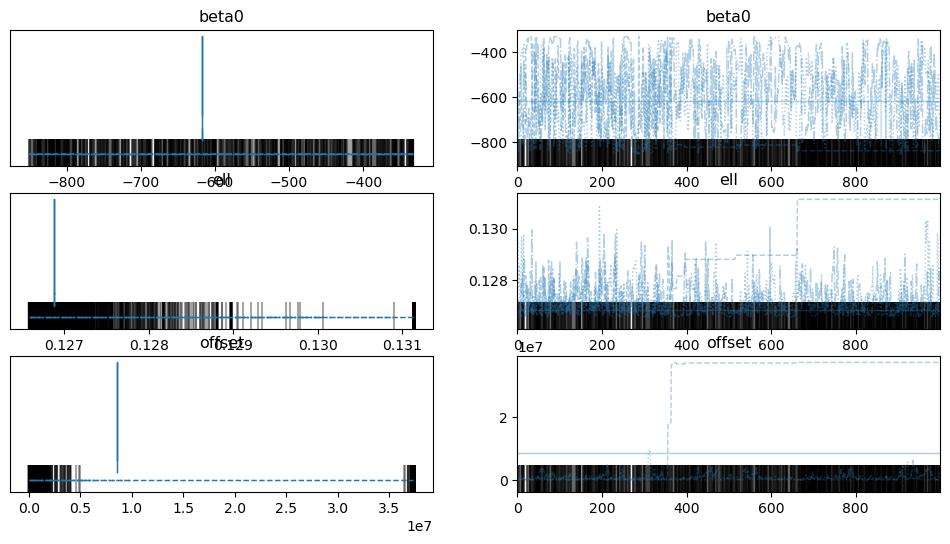

In [60]:
az.plot_trace(hyperpar_samples)
plt.show()

# Prediction at Test Points

In [21]:
with gpModel1: 
    pred1 = gp1.predict(Xnew=X_test, point=hyperpar_estimates1, diag=True)
    pred1_extrap = gp1.predict(Xnew=X_test_extrap, point=hyperpar_estimates1, diag=True)

In [55]:
with gpModel2:
    pred2 = gp2.predict(Xnew=X_test, point=hyperpar_estimates2, diag=True)
    pred2_extrap = gp2.predict(Xnew=X_test_extrap, point=hyperpar_estimates2, diag=True)

# Investigate GP Fits. 

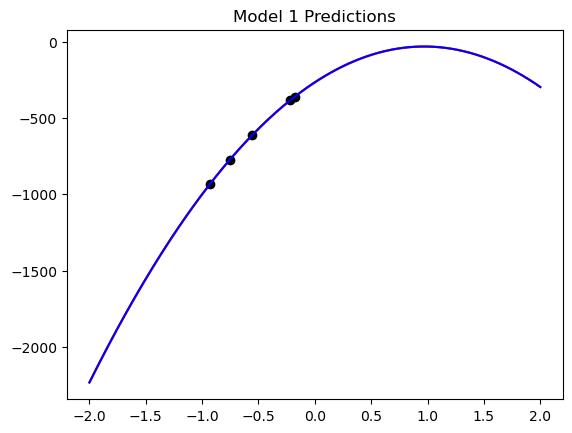

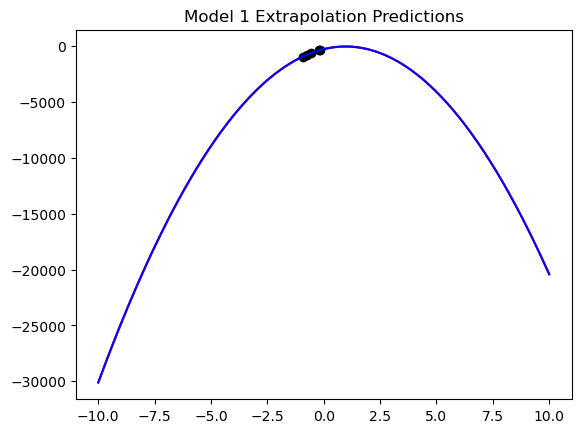

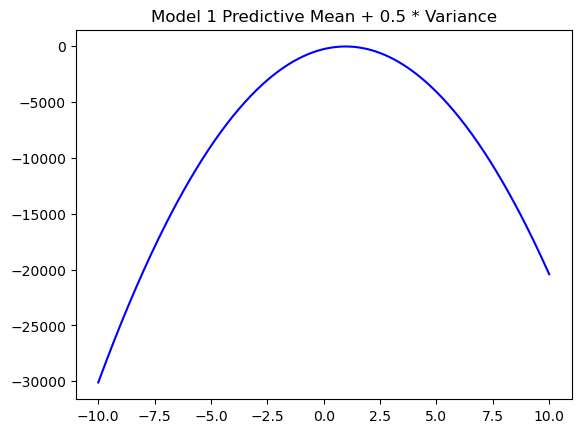

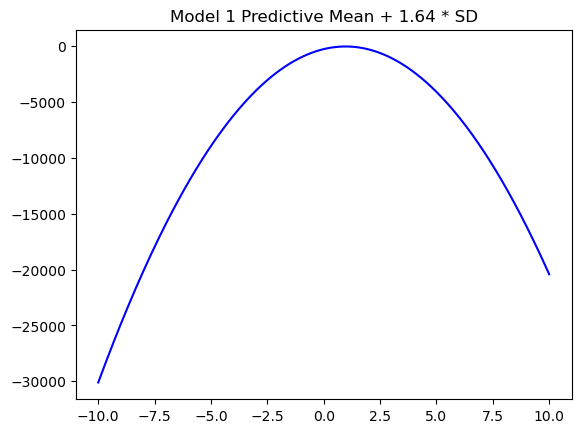

In [27]:
# Model 1
pred_mean1 = pred1[0]
pred_sd1 = np.sqrt(np.maximum(pred1[1], 0))

pred_mean1_extrap = pred1_extrap[0]
pred_sd1_extrap = np.sqrt(np.maximum(pred1_extrap[1], 0))

# Prediction plot. 
plt.plot(X_test, y_test, "r")
plt.plot(X_design, y_design, "ko")
plt.plot(X_test, pred_mean1, "b")
plt.fill_between(X_test[:,0], pred_mean1-2*pred_sd1, pred_mean1+2*pred_sd1, color="gray", alpha=0.3)
plt.title("Model 1 Predictions")
plt.show()

# Extrapolation plot.
plt.plot(X_test_extrap, y_test_extrap, "r")
plt.plot(X_design, y_design, "ko")
plt.plot(X_test_extrap, pred_mean1_extrap, "b")
plt.fill_between(X_test_extrap[:,0], pred_mean1_extrap-2*pred_sd1_extrap, 
                 pred_mean1_extrap+2*pred_sd1_extrap, color="gray", alpha=0.3)
plt.title("Model 1 Extrapolation Predictions")
plt.show()

# Mean Plus 0.5*variance.
plt.plot(X_test_extrap, pred_mean1_extrap + 0.5*np.power(pred_sd1_extrap,2), "b")
plt.title("Model 1 Predictive Mean + 0.5 * Variance")
plt.show()

# Mean Plus 1.64*SD.
plt.plot(X_test_extrap, pred_mean1_extrap + 1.64*pred_sd1_extrap, "b")
plt.title("Model 1 Predictive Mean + 1.64 * SD")
plt.show()



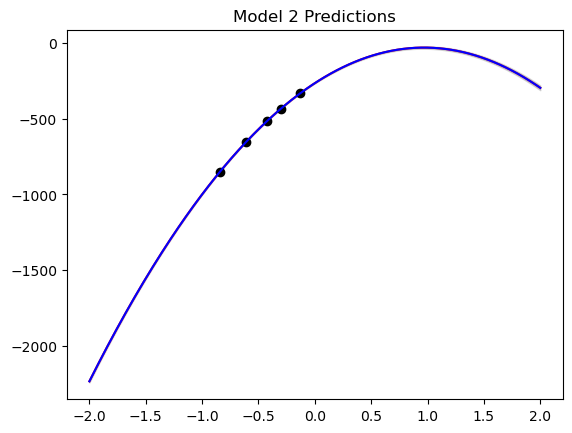

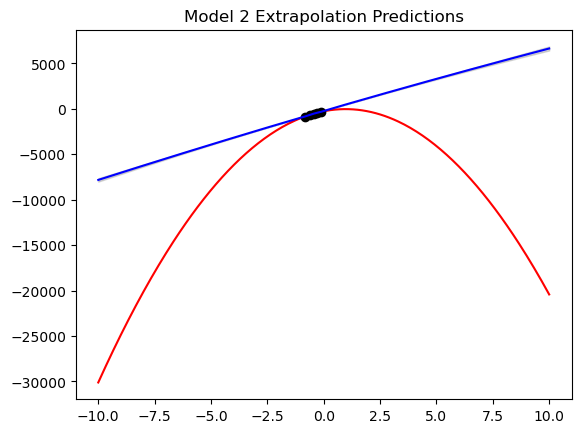

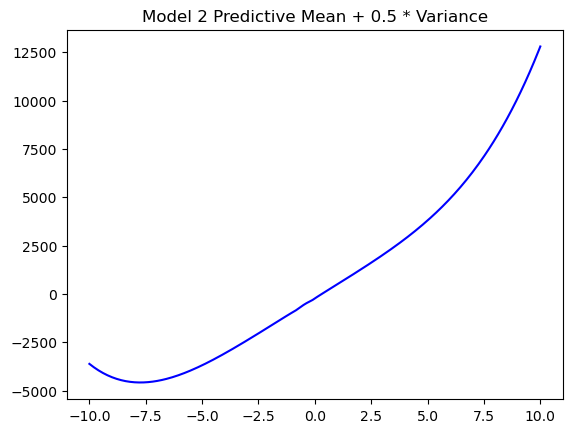

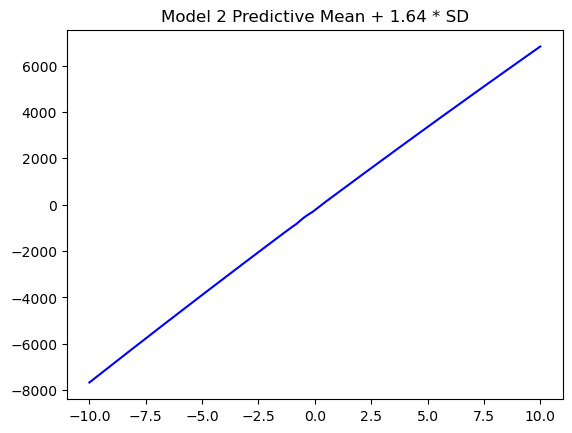

In [56]:
# Model 2
pred_mean2 = pred1[0]
pred_sd2 = np.sqrt(np.maximum(pred2[1], 0))

pred_mean2_extrap = pred2_extrap[0]
pred_sd2_extrap = np.sqrt(np.maximum(pred2_extrap[1], 0))

# Prediction plot. 
plt.plot(X_test, y_test, "r")
plt.plot(X_design, y_design, "ko")
plt.plot(X_test, pred_mean2, "b")
plt.fill_between(X_test[:,0], pred_mean2-2*pred_sd2, pred_mean2+2*pred_sd2, color="gray", alpha=0.3)
plt.title("Model 2 Predictions")
plt.show()

# Extrapolation plot.
plt.plot(X_test_extrap, y_test_extrap, "r")
plt.plot(X_design, y_design, "ko")
plt.plot(X_test_extrap, pred_mean2_extrap, "b")
plt.fill_between(X_test_extrap[:,0], pred_mean2_extrap-2*pred_sd2_extrap, 
                 pred_mean2_extrap+2*pred_sd2_extrap, color="gray", alpha=0.3)
plt.title("Model 2 Extrapolation Predictions")
plt.show()

# Mean Plus 0.5*variance.
plt.plot(X_test_extrap, pred_mean2_extrap + 0.5*np.power(pred_sd2_extrap,2), "b")
plt.title("Model 2 Predictive Mean + 0.5 * Variance")
plt.show()

# Mean Plus 1.64*SD.
plt.plot(X_test_extrap, pred_mean2_extrap + 1.64*pred_sd2_extrap, "b")
plt.title("Model 2 Predictive Mean + 1.64 * SD")
plt.show()



In [12]:
# GP 1:
#   - quadratic trend; Basis functions h(x) = [1, x, x^2]
#   - Gaussian kernel.
#   - Flat priors (to assess maximum marginal likelihood approach to hyperparameter estimation). 
#
# TODO: use a better numerically behaved basis from NumPy's polynomial class. 

with pm.Model() as gpModel1:
    # Polynomial basis functions evaluated at design. 
    # H = np.column_stack((np.ones(n_design), X_design, np.power(X_design, 2)))
    # q = H.shape[1]

    # Coefficient vector for mean function. Uninformative prior. 
    # beta = pm.MvNormal("beta", mu=np.zeros(q), cov=np.diag(100*np.ones(q)))

    # Flat prior on coefficients.
    # TODO: instead of flat prior, define this as a deterministic function of the other 
    # hyperparameters, using the profile marginal likelihood approach. Wrap it in 
    # pm.Deterministic() and give it a name so that it is tracked. 
    q = 3
    beta = pm.Flat("beta", shape=(q,))

    # Flat prior on lengthscale.  
    ell = pm.Flat("ell")

    # Flat prior on marginal standard deviation. 
    alpha = pm.Flat("alpha")
    
    # Kernel. 
    kernel = alpha**2 * pm.gp.cov.ExpQuad(1, ell)

    # Mean function. 
    mean_func = pm.gp.mean.Linear(coeffs=beta[0:q], intercept=beta[q])

    # Specify the GP..
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=kernel)

    # Define the GP marginal likelihood. No observation noise, fixed jitter.   
    y_ = gp.marginal_likelihood("y", X=X_design, y=y_design, sigma=0, jitter=1e-06)


In [18]:
beta.ndim_supp

AttributeError: 'TensorVariable' object has no attribute 'ndim_supp'

In [13]:
with gpModel1: 
    MAP = pm.find_MAP()

ValueError: Shape mismatch: x has 1 cols (and 5 rows) but y has 3 rows (and 1 cols)
Apply node that caused the error: Dot22([[-0.95305 ... 14542   ]], ExpandDims{axis=1}.0)
Toposort index: 9
Inputs types: [TensorType(float64, shape=(5, 1)), TensorType(float64, shape=(3, 1))]
Inputs shapes: [(5, 1), (3, 1)]
Inputs strides: [(8, 40), (8, 8)]
Inputs values: [array([[-0.95305962],
       [-0.72644533],
       [-0.47986599],
       [-0.28005846],
       [-0.14542   ]]), array([[0.],
       [0.],
       [0.]])]
Outputs clients: [[Composite{(i2 - (i0 + i1))}(Dot22.0, ExpandDims{axes=[0, 1]}.0, [[-954.205 ... 18915478]])]]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.